In [ ]:
# ==========================================
# XGBoost 하루 순차 예측 + SHAP (최적화 버전)
# ==========================================
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# logger import
sys.path.append(r"C:\ESG_Project1\util")
from logger import setup_logger
logger = setup_logger(__name__)

# -------------------------------
# 설정
# -------------------------------
TRAIN_CSV   = r"C:\ESG_Project1\file\merge_data\train_data.csv"
TEST_CSV    = r"C:\ESG_Project1\file\merge_data\test_data.csv"
OUT_DIR     = r"C:\ESG_Project1\xgboost\output"
SAVED_MODEL = os.path.join(OUT_DIR, "xgb_daily_shap.pkl")
SAVED_META  = os.path.join(OUT_DIR, "xgb_daily_shap_meta.json")

TARGET_COL = "합산발전량(MWh)"
LAGS = [1,2,3,4,8,12]
ROLLS = [4,8,12]
SEED = 42
DO_SHAP = True
np.random.seed(SEED)
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# 한글 폰트
# -------------------------------
def set_korean_font():
    candidates = ['Malgun Gothic','AppleGothic','NanumGothic','Noto Sans CJK KR']
    installed = set(f.name for f in font_manager.fontManager.ttflist)
    for name in candidates:
        if name in installed:
            rcParams['font.family'] = name
            break
    rcParams['axes.unicode_minus'] = False
set_korean_font()

# -------------------------------
# 유틸 함수
# -------------------------------
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"mae":mae, "rmse":rmse, "r2":r2}

def detect_datetime(df):
    for c in ["일시","datetime","timestamp","DATE_TIME","date_time"]:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors="coerce")
            if dt.notna().any():
                return dt
    raise ValueError("datetime 열을 찾을 수 없습니다.")

def make_features(df, target_col):
    dt = detect_datetime(df)
    df = df.copy()
    df["__dt__"] = dt
    df = df.set_index("__dt__").sort_index()
    wk = df[[target_col]].copy()
    
    # 날짜 관련 feature
    wk["year"]       = wk.index.year
    wk["weekofyear"] = wk.index.isocalendar().week.astype(int)
    wk["month"]      = wk.index.month
    wk["quarter"]    = wk.index.quarter
    wk["dayofweek"]  = wk.index.dayofweek
    
    # 주기성 변환
    wk["week_sin"]   = np.sin(2*np.pi*wk["weekofyear"]/52.0)
    wk["week_cos"]   = np.cos(2*np.pi*wk["weekofyear"]/52.0)
    wk["month_sin"]  = np.sin(2*np.pi*wk["month"]/12.0)
    wk["month_cos"]  = np.cos(2*np.pi*wk["month"]/12.0)
    wk["day_sin"]    = np.sin(2*np.pi*wk["dayofweek"]/7.0)
    wk["day_cos"]    = np.cos(2*np.pi*wk["dayofweek"]/7.0)
    
    # Lag / Rolling feature (기본적으로 학습 데이터에서만 생성)
    for l in LAGS:
        wk[f"lag_{l}"] = wk[target_col].shift(l)
    for r in ROLLS:
        wk[f"roll_mean_{r}"] = wk[target_col].shift(1).rolling(r).mean()
        wk[f"roll_std_{r}"]  = wk[target_col].shift(1).rolling(r).std()
    
    wk = wk.dropna().copy()
    return wk

# -------------------------------
# 데이터 로드
# -------------------------------
train_raw = pd.read_csv(TRAIN_CSV, encoding="utf-8", low_memory=False)
test_raw  = pd.read_csv(TEST_CSV, encoding="utf-8", low_memory=False)
logger.info("CSV 파일 로드 완료")

train_feat = make_features(train_raw, TARGET_COL)
test_feat  = make_features(test_raw, TARGET_COL)

# 문자열 숫자(float로 변환)
train_feat = train_feat.applymap(lambda x: float(x.strip("[]")) if isinstance(x, str) and x.startswith("[") else x)
test_feat  = test_feat.applymap(lambda x: float(x.strip("[]")) if isinstance(x, str) and x.startswith("[") else x)

# -------------------------------
# X, y 분리
# -------------------------------
X_train_full = train_feat.drop(columns=[TARGET_COL])
y_train_full = train_feat[TARGET_COL]
X_test_full  = test_feat.drop(columns=[TARGET_COL])
y_test_full  = test_feat[TARGET_COL]

# -------------------------------
# 1) 전체 학습 (2025년 이전)
# -------------------------------
dtrain = xgb.DMatrix(X_train_full, label=y_train_full)
booster = xgb.train(
    {"objective":"reg:squarederror","tree_method":"hist","max_depth":6,"eta":0.03,"seed":SEED},
    dtrain, num_boost_round=500
)
logger.info("기본 XGBoost 학습 완료")

# -------------------------------
# 2) 순차 하루 예측 (모델 재학습 없이)
# -------------------------------
pred_list = []
history_feat = pd.concat([X_train_full, y_train_full.rename("target")], axis=1)

for i in range(len(X_test_full)):
    x_pred = X_test_full.iloc[i:i+1].copy()
    
    # Lag/rolling feature 업데이트
    for l in LAGS:
        x_pred[f"lag_{l}"] = history_feat["target"].iloc[-l]
    for r in ROLLS:
        x_pred[f"roll_mean_{r}"] = history_feat["target"].iloc[-r:].mean()
        x_pred[f"roll_std_{r}"]  = history_feat["target"].iloc[-r:].std()
    
    # 예측
    y_hat = booster.predict(xgb.DMatrix(x_pred))[0]
    pred_list.append(y_hat)
    
    # history 업데이트
    history_feat = pd.concat([history_feat, pd.DataFrame({**x_pred.iloc[0].to_dict(), "target": y_hat}, index=[x_pred.index[0]])])

# -------------------------------
# 3) 결과 평가
# -------------------------------
result_2025 = pd.DataFrame({
    "actual": y_test_full,
    "pred": pred_list
}, index=X_test_full.index)

metrics_test = metrics(y_test_full, pred_list)
logger.info(f"[테스트 데이터 전체] MAE={metrics_test['mae']:.3f}, RMSE={metrics_test['rmse']:.3f}, R2={metrics_test['r2']:.4f}")

# -------------------------------
# 4) 시각화
# -------------------------------
y_true = result_2025["actual"]
y_pred = result_2025["pred"]
dt_col = result_2025.index

# 시계열 + RMSE 밴드
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
plt.figure(figsize=(12,4))
plt.plot(dt_col, y_true, label="실제", linewidth=1.2)
plt.plot(dt_col, y_pred, label="예측", linewidth=1.2)
plt.fill_between(dt_col, y_pred - rmse_val, y_pred + rmse_val, color='orange', alpha=0.2, label=f"±RMSE ({rmse_val:.2f})")
plt.xlabel("날짜")
plt.ylabel("발전량 (MWh)")
plt.title("테스트 데이터 실제 vs 예측 발전량 (±RMSE 밴드)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 산점도
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.35, edgecolor='k', linewidth=0.2)
min_v, max_v = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--', linewidth=2)
plt.xlabel("실제 발전량 (MWh)")
plt.ylabel("예측 발전량 (MWh)")
plt.title("실제값 vs 예측값")
plt.grid(True)
plt.tight_layout()
plt.show()

# 잔차 분포
errors = y_pred - y_true
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(errors.mean(), linestyle='dashed', linewidth=2, label=f"평균 오차 = {errors.mean():.2f}")
plt.xlabel("예측 오차 (MWh)")
plt.ylabel("빈도")
plt.title("예측 오차 분포 (Residual)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 5) SHAP 시각화
# -------------------------------
if DO_SHAP:
    try:
        import shap
        X_shap = pd.concat([X_train_full, X_test_full]).astype(float)
        y_shap = pd.concat([y_train_full, pd.Series(pred_list, index=X_test_full.index)])
        dtrain_full = xgb.DMatrix(X_shap, label=y_shap)
        booster_full = xgb.train(
            {"objective":"reg:squarederror","tree_method":"hist","max_depth":6,"eta":0.03,"seed":SEED},
            dtrain_full, num_boost_round=500
        )
        explainer = shap.TreeExplainer(booster_full)
        shap_values = explainer.shap_values(X_shap)
        shap.summary_plot(shap_values, X_shap, plot_type="bar")
    except Exception as e:
        logger.warning(f"SHAP 시각화 실패: {e}")


[2025-10-24 11:16:53,515]✅ INFO - CSV 파일 로드 완료
[2025-10-24 11:17:30,447]✅ INFO - 기본 XGBoost 학습 완료


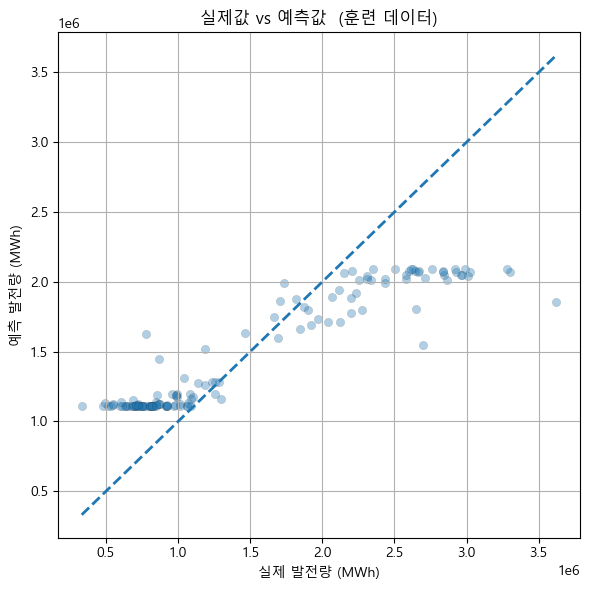

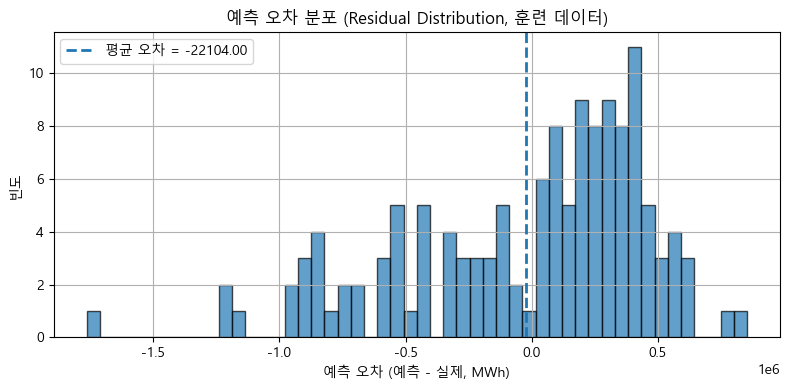

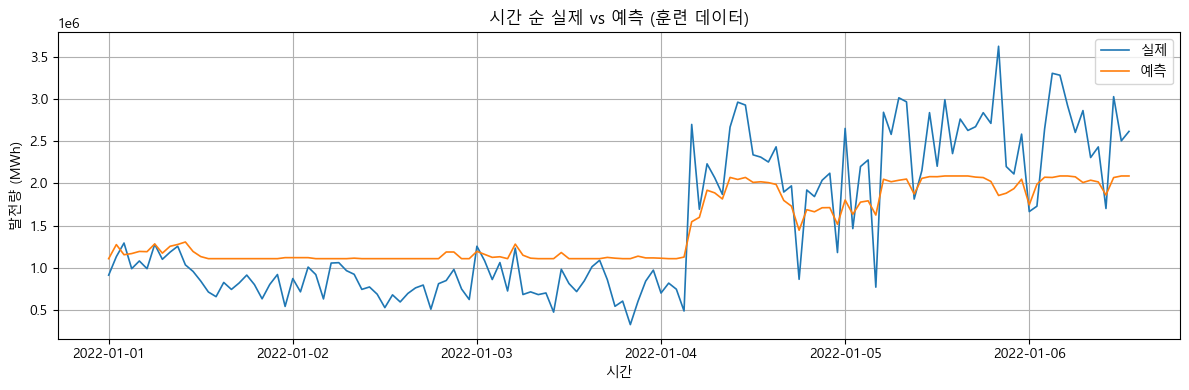

In [ ]:
# -------------------------------
# 6) 시각화
# -------------------------------

# dt_col: 원본 datetime 열 이름 지정 (없으면 None)
dt_col = None
for c in ["일시","datetime","timestamp","DATE_TIME","date_time"]:
    if c in raw.columns:
        dt_col = c
        break

# 6-1) 실제 vs 예측 산점도 (훈련)
y_true = y_train
y_pred = pred_train
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.35, edgecolor='k', linewidth=0.2)
min_v = float(min(y_true.min(), y_pred.min()))
max_v = float(max(y_true.max(), y_pred.max()))
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--', linewidth=2)
plt.xlabel("실제 발전량 (MWh)")
plt.ylabel("예측 발전량 (MWh)")
plt.title("실제값 vs 예측값  (훈련 데이터)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6-2) 예측 오차 분포
errors = y_pred - y_true
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(errors.mean(), linestyle='dashed', linewidth=2, label=f"평균 오차 = {errors.mean():.2f}")
plt.xlabel("예측 오차 (예측 - 실제, MWh)")
plt.ylabel("빈도")
plt.title("예측 오차 분포 (Residual Distribution, 훈련 데이터)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6-3) 시계열 추세 (datetime 있는 경우)
if dt_col is not None:
    dt_values = pd.to_datetime(raw[dt_col], errors="coerce")
    # 학습 구간만 선택
    dt_values = dt_values.iloc[:train_end]
    order = np.argsort(dt_values.values)
    plt.figure(figsize=(12,4))
    plt.plot(dt_values.values[order], y_true.values[order], label="실제", linewidth=1.2)
    plt.plot(dt_values.values[order], np.array(y_pred)[order], label="예측", linewidth=1.2)
    plt.xlabel("시간")
    plt.ylabel("발전량 (MWh)")
    plt.title("시간 순 실제 vs 예측 (훈련 데이터)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
